In [ ]:
from fastai.vision.all import *
from faststyle import *

In [ ]:
source = Path('/storage/data/cat-dataset/cats')

In [ ]:
class RandomErasingX(RandomErasing):
  split_idx=None
  def encodes(self, x:TensorImage):  return x
  def encodes(self, x:TensorImageX): return super().encodes(x)

In [ ]:
dblock = DataBlock((ImageBlock(PILImageX), ImageBlock),
                   get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(256)],
                   batch_tfms=[RandomErasingX(p=.8), NormalizeX.from_stats(*imagenet_stats)],
                  )

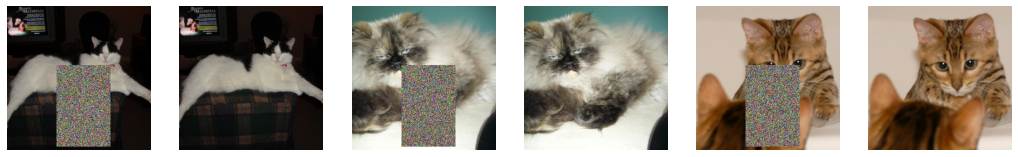

In [ ]:
dls = dblock.dataloaders(source, bs=8); dls.c = 3
dls.show_batch(max_n=3)

In [ ]:
feat_m = prepare_feat_model(vgg16_bn(True).features)
get_fts = LayerFeats(feat_m, stl_ls=[], cnt_ls=get_layers(feat_m, [12,22,32]),
                     tfms=NormalizeAll.from_stats(*imagenet_stats))

In [ ]:
cnt_loss = partial(content_loss, layer_ws=[5,15,2])
loss_func = SuperResLoss(cnt_loss=cnt_loss)

In [ ]:
cbs = [FeatsCallback(get_fts)]
metrics = loss_func.metrics
cfg = unet_config(blur=True, self_attention=True, norm_type=NormType.Weight, y_range=(0.,1.))
learn = unet_learner(dls=dls, arch=resnet34, loss_func=loss_func, cbs=cbs,
                     metrics=metrics, config=cfg)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0008317637839354575)

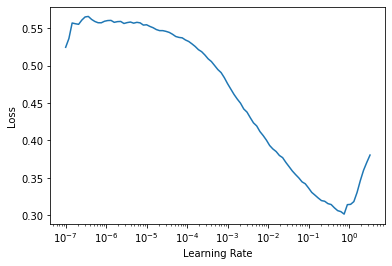

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 3e-2, pct_start=.9)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.070715,0.073857,0.008200,0.065657,07:44
1,0.067672,0.063320,0.004348,0.058972,07:44
2,0.064632,0.066670,0.004835,0.061835,07:44
3,0.069071,0.060610,0.004202,0.056409,07:44
4,0.048566,0.060737,0.003982,0.056755,07:44


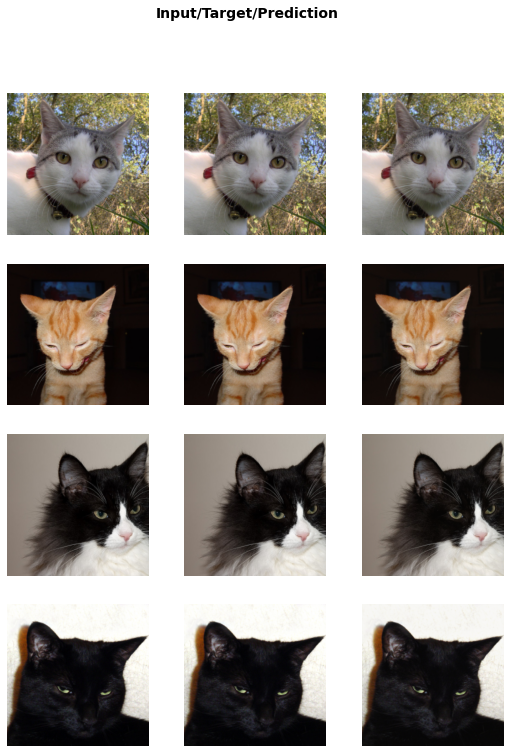

In [ ]:
learn.show_results()

In [ ]:
learn.save('inpainting_cats')

Path('models/inpainting_cats.pth')